<a href="https://colab.research.google.com/github/anggaps/Academy/blob/master/insectClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-09-21 17:31:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-21 17:31:54 (94.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
dataset = "/content/Classification/Classification/ip102_v1.1/train"
walk_through_dir(dataset)

There are 102 directories and 0 images in '/content/Classification/Classification/ip102_v1.1/train'.
There are 0 directories and 989 images in '/content/Classification/Classification/ip102_v1.1/train/mole cricket'.
There are 0 directories and 186 images in '/content/Classification/Classification/ip102_v1.1/train/Adristyrannus'.
There are 0 directories and 516 images in '/content/Classification/Classification/ip102_v1.1/train/grub'.
There are 0 directories and 183 images in '/content/Classification/Classification/ip102_v1.1/train/Chlumetia transversa'.
There are 0 directories and 135 images in '/content/Classification/Classification/ip102_v1.1/train/Chrysomphalus aonidum'.
There are 0 directories and 291 images in '/content/Classification/Classification/ip102_v1.1/train/wheat blossom midge'.
There are 0 directories and 339 images in '/content/Classification/Classification/ip102_v1.1/train/Potosiabre vitarsis'.
There are 0 directories and 55 images in '/content/Classification/Classificat

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath              Label
0      /content/Classification/Classification/ip102_v...       mole cricket
1      /content/Classification/Classification/ip102_v...       mole cricket
2      /content/Classification/Classification/ip102_v...       mole cricket
3      /content/Classification/Classification/ip102_v...       mole cricket
4      /content/Classification/Classification/ip102_v...       mole cricket
...                                                  ...                ...
45090  /content/Classification/Classification/ip102_v...  odontothrips loti
45091  /content/Classification/Classification/ip102_v...  odontothrips loti
45092  /content/Classification/Classification/ip102_v...  odontothrips loti
45093  /content/Classification/Classification/ip102_v...  odontothrips loti
45094  /content/Classification/Classification/ip102_v...  odontothrips loti

[45095 rows x 2 columns]

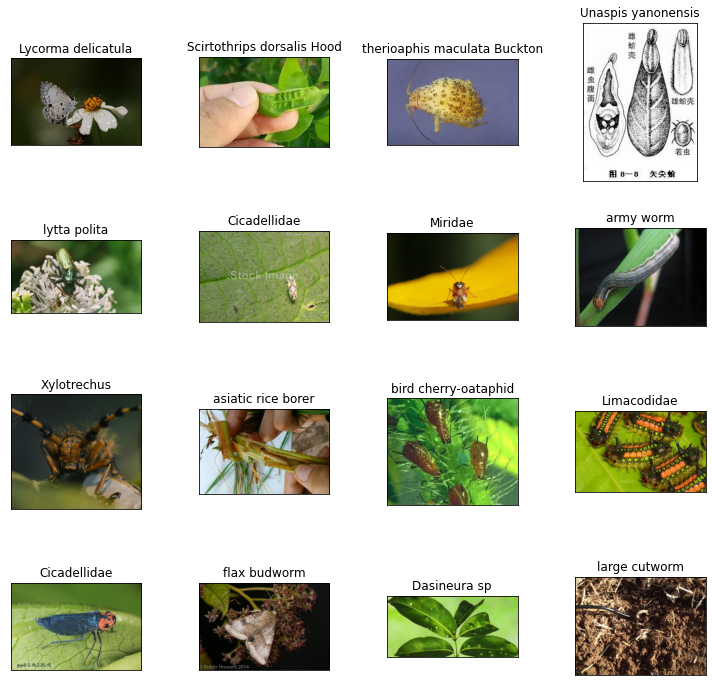

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

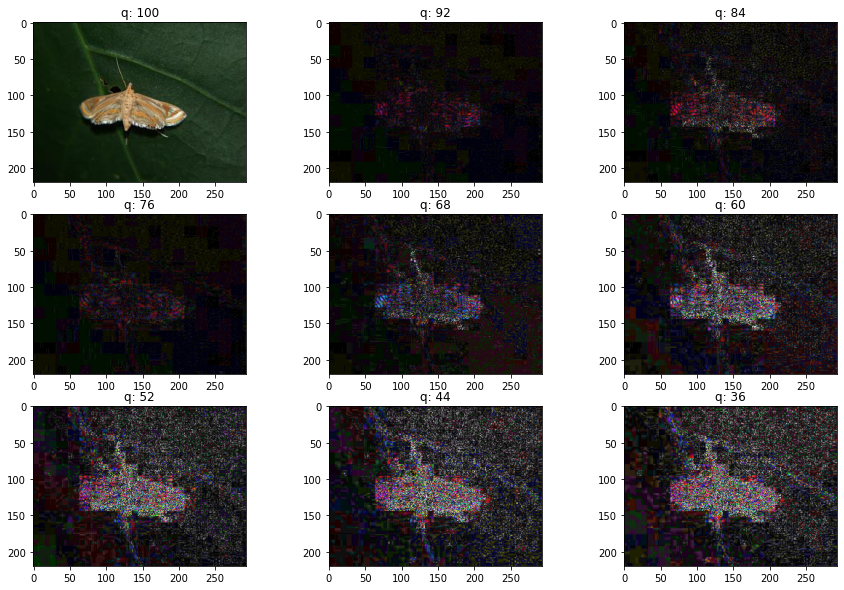

In [ ]:
# View random sample from the dataset
p = random_sample('/content/Classification/Classification/ip102_v1.1/train/Adristyrannus')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 28861 validated image filenames belonging to 102 classes.
Found 7215 validated image filenames belonging to 102 classes.
Found 9019 validated image filenames belonging to 102 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "insect_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(102, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "insect_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/insect_classification/20220921-173315
Epoch 1/50
902/902 [==============================] - 224s 233ms/step - loss: 4.4766 - accuracy: 0.0766 - val_loss: 4.0397 - val_accuracy: 0.1590
Epoch 2/50
902/902 [==============================] - 208s 230ms/step - loss: 3.9909 - accuracy: 0.1632 - val_loss: 3.7251 - val_accuracy: 0.2076
Epoch 3/50
902/902 [==============================] - 209s 232ms/step - loss: 3.7339 - accuracy: 0.2038 - val_loss: 3.4891 - val_accuracy: 0.2568
Epoch 4/50
902/902 [==============================] - 211s 234ms/step - loss: 3.5266 - accuracy: 0.2408 - val_loss: 3.2948 - val_accuracy: 0.2875
Epoch 5/50
902/902 [==============================] - 203s 225ms/step - loss: 3.3698 - accuracy: 0.2642 - val_loss: 3.1390 - val_accuracy: 0.3105
Epoch 6/50
902/902 [==============================] - 205s 227ms/step - loss: 3.2366 - accuracy: 0.2894 - val_loss: 3.0133 - val_accuracy: 0.3324
Epoch 7/50
902/902 [===================

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.80254
Test Accuracy: 53.71%


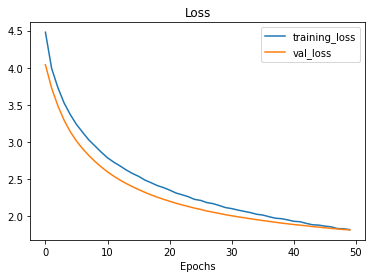

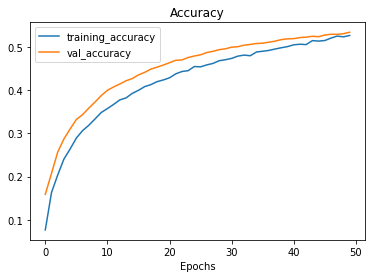

In [ ]:
plot_loss_curves(history)


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['beet weevil', 'Panonchus citri McGregor', 'aphids', 'Xylotrechus', 'Cicadellidae']


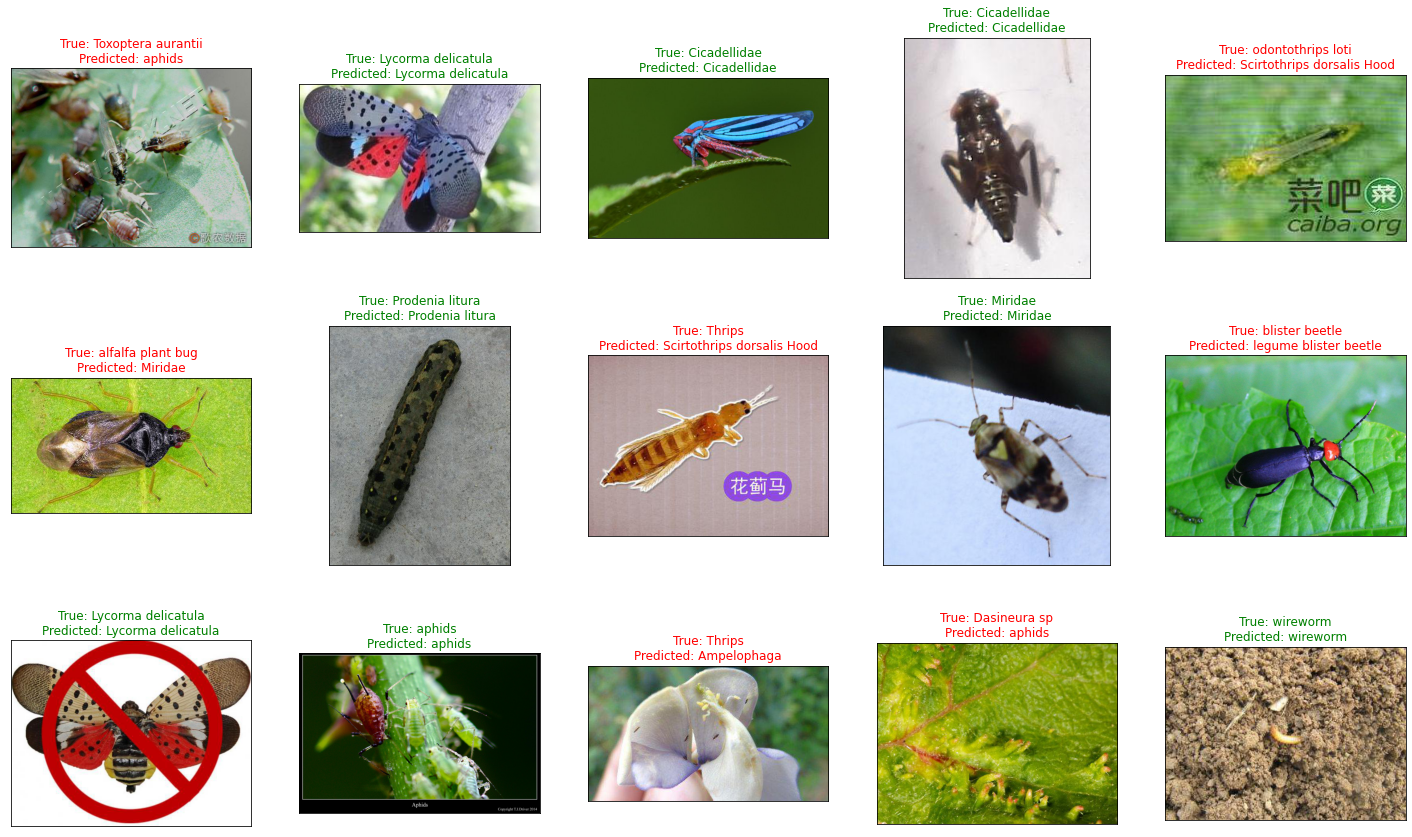

<Figure size 432x288 with 0 Axes>

In [ ]:
 # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                 precision    recall  f1-score   support

                  Adristyrannus       0.60      0.39      0.47        31
       Aleurocanthus spiniferus       0.59      0.74      0.66        82
                    Ampelophaga       0.57      0.63      0.60       102
    Aphis citricola Vander Goot       0.53      0.22      0.31        46
               Apolygus lucorum       0.20      0.02      0.04        51
           Bactrocera tsuneonis       0.25      0.07      0.11        15
                Beet spot flies       0.46      0.40      0.42        43
   Brevipoalpus lewisi McGregor       0.00      0.00      0.00         9
             Ceroplastes rubens       0.75      0.38      0.51        39
           Chlumetia transversa       0.71      0.13      0.22        38
          Chrysomphalus aonidum       0.57      0.46      0.51        28
              Cicadella viridis       0.64      0.51      0.57       146
                   Cicadellidae       0.71      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(50, 50), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

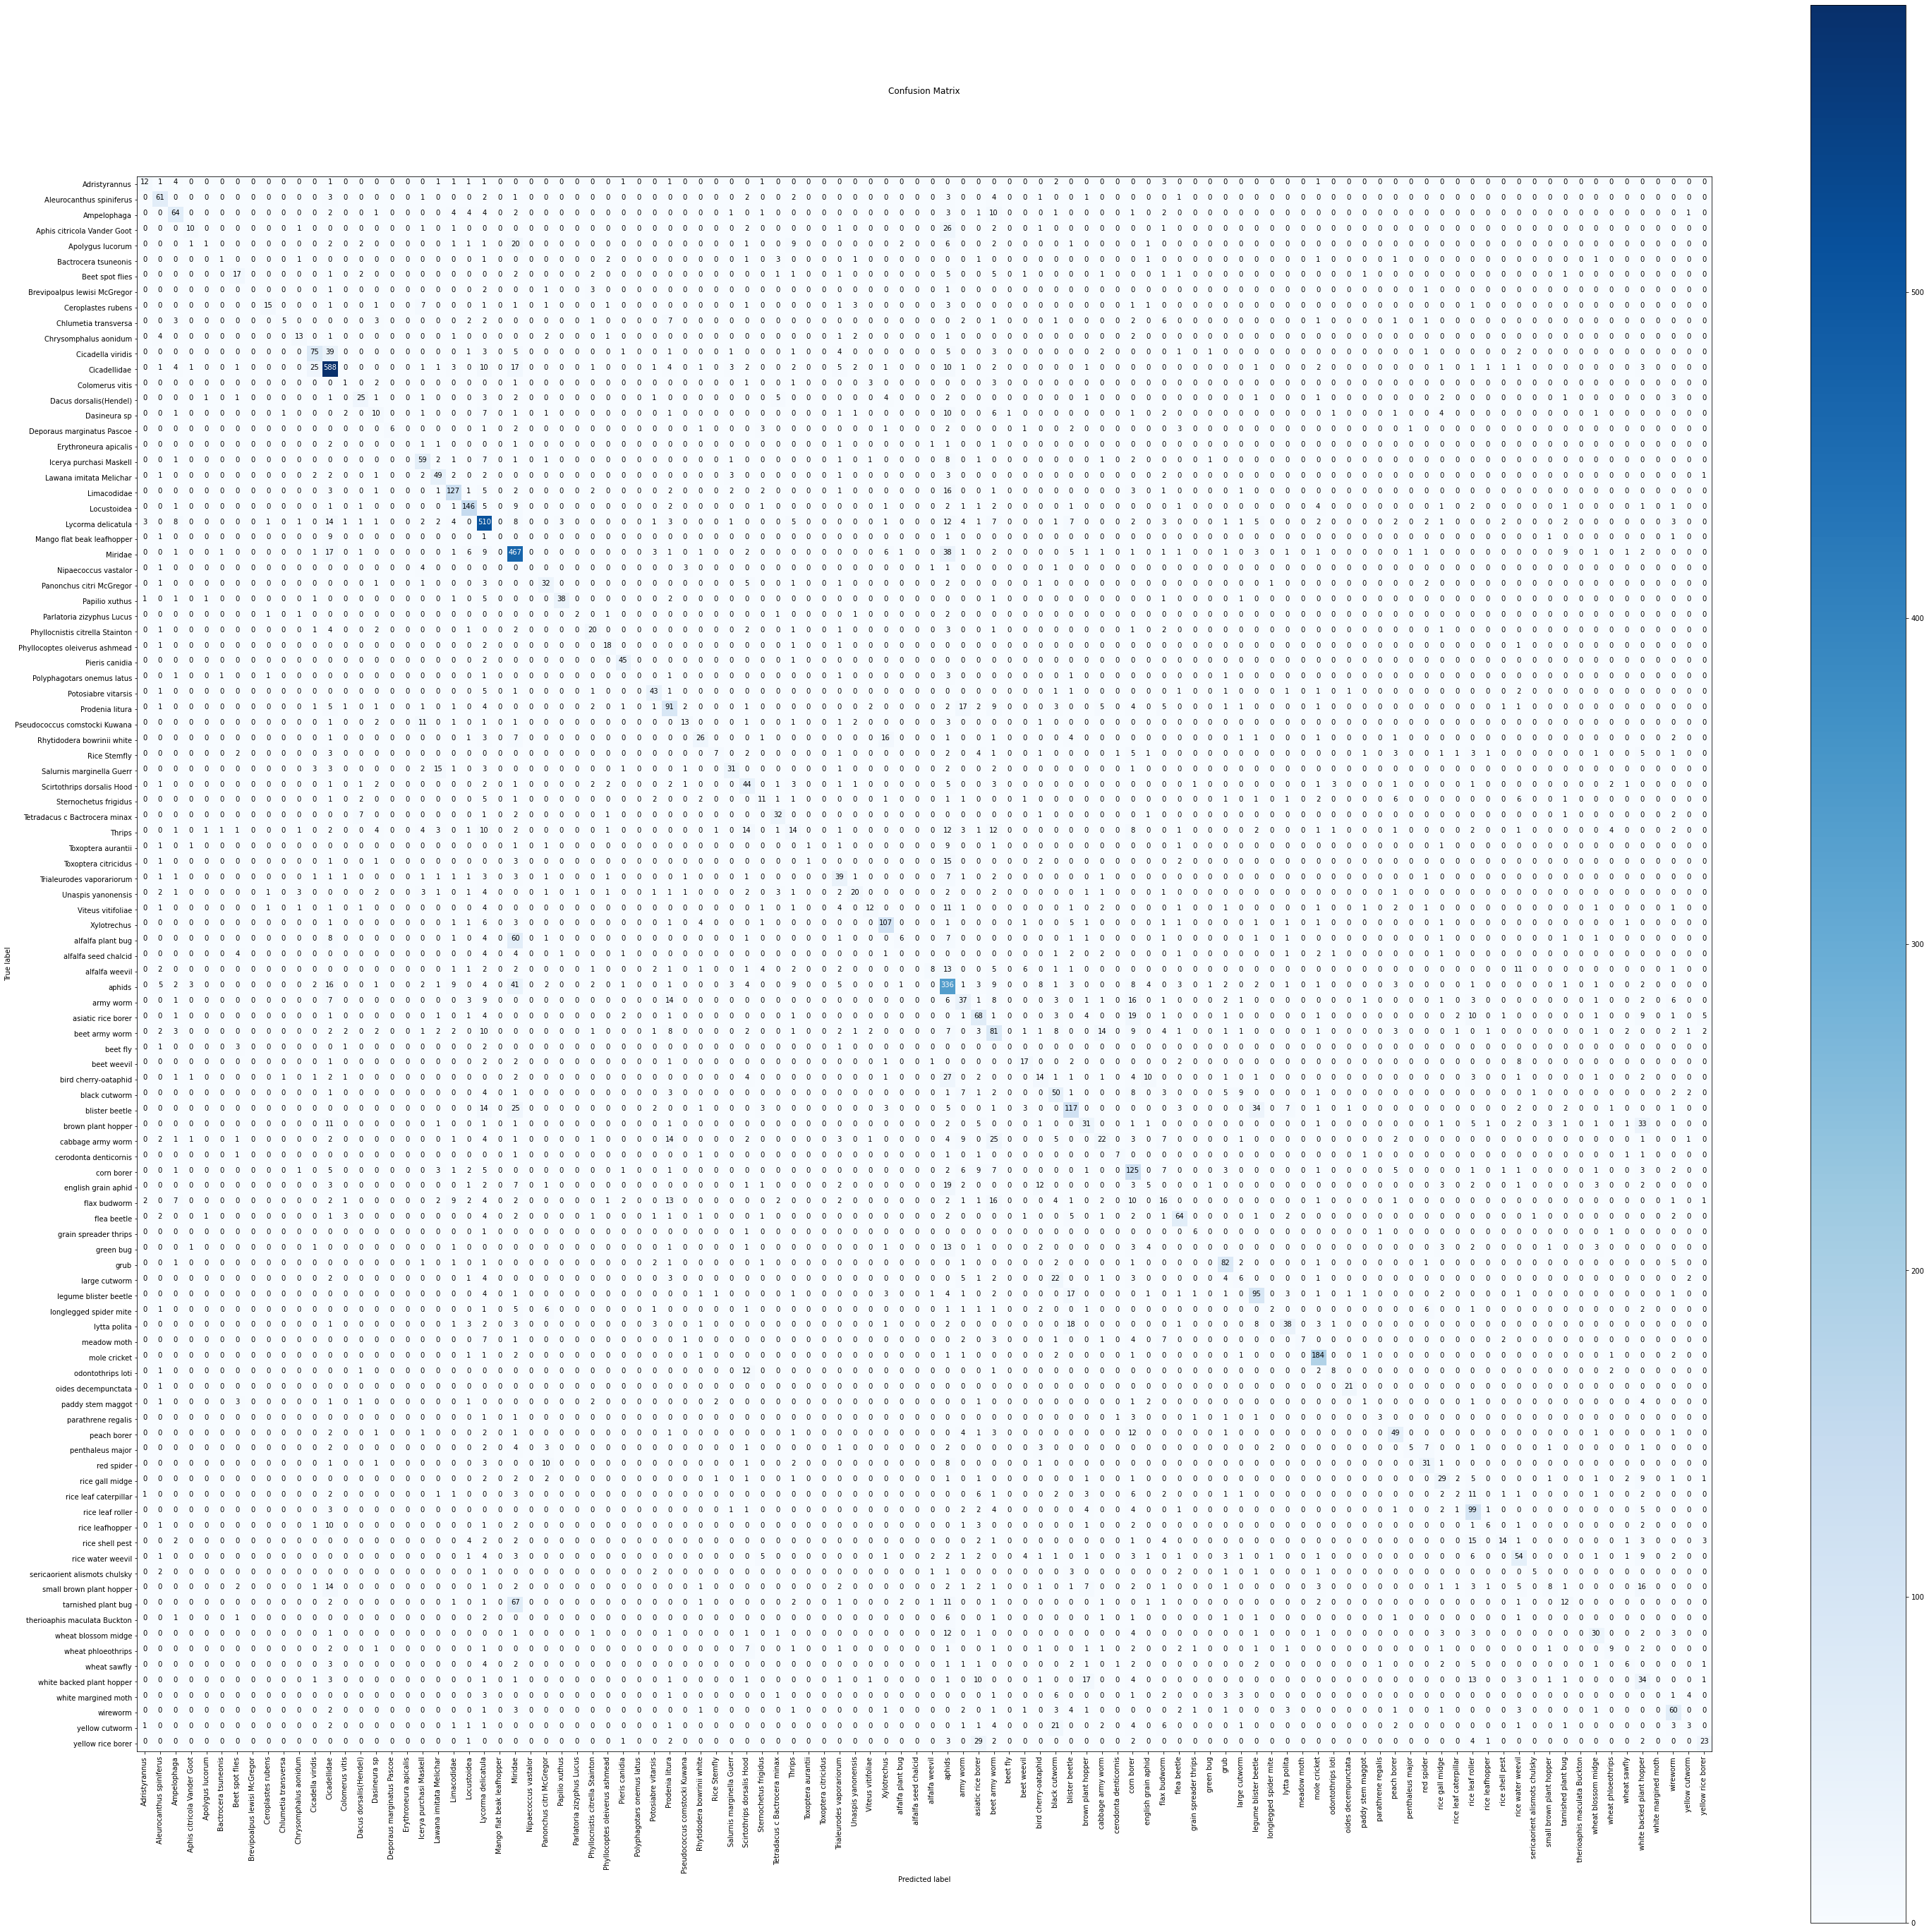

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))


In [ ]:
pretrained_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  264


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

In [ ]:
len(model.trainable_variables)


98

In [ ]:
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:

history_fine  = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "insect_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/insect_classification/20220921-203230
Epoch 1/50
902/902 [==============================] - 220s 244ms/step - loss: 2.0133 - accuracy: 0.4853 - val_loss: 1.8182 - val_accuracy: 0.5361
Epoch 2/50
902/902 [==============================] - 216s 240ms/step - loss: 1.8888 - accuracy: 0.5109 - val_loss: 1.7722 - val_accuracy: 0.5473
Epoch 3/50
902/902 [==============================] - 219s 243ms/step - loss: 1.8007 - accuracy: 0.5292 - val_loss: 1.7300 - val_accuracy: 0.5550
Epoch 4/50
902/902 [==============================] - 215s 238ms/step - loss: 1.7371 - accuracy: 0.5446 - val_loss: 1.6969 - val_accuracy: 0.5616
Epoch 5/50
902/902 [==============================] - 220s 244ms/step - loss: 1.6691 - accuracy: 0.5591 - val_loss: 1.6689 - val_accuracy: 0.5663
Epoch 6/50
902/902 [==============================] - 223s 247ms/step - loss: 1.6141 - accuracy: 0.5684 - val_loss: 1.6410 - val_accuracy: 0.5737
Epoch 7/50
902/902 [===================

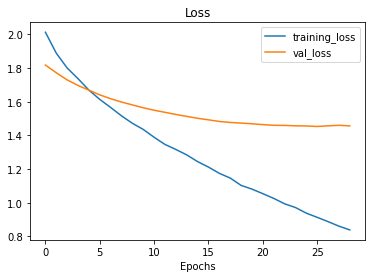

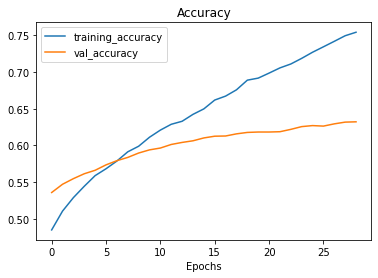

In [ ]:
plot_loss_curves(history_fine)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['alfalfa weevil', 'Chrysomphalus aonidum', 'aphids', 'Xylotrechus', 'flax budworm']


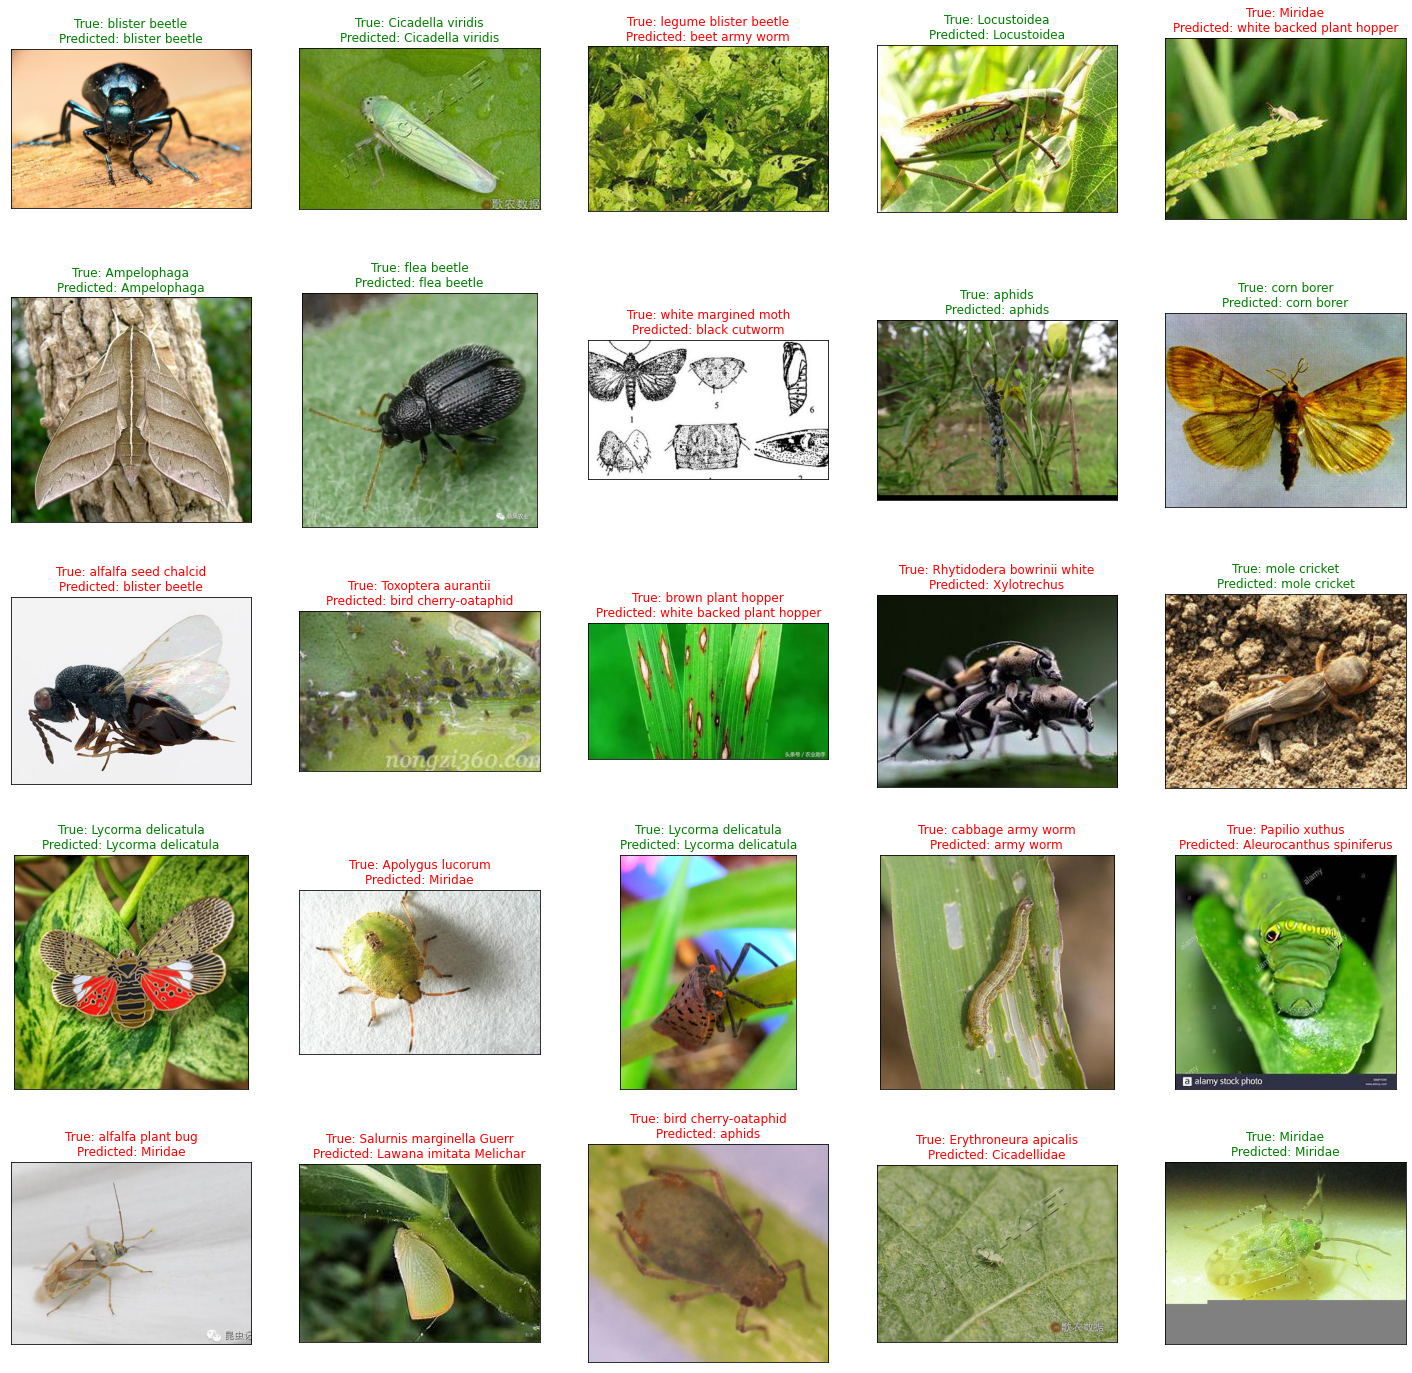

<Figure size 432x288 with 0 Axes>

In [ ]:
 # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                                 precision    recall  f1-score   support

                  Adristyrannus       0.62      0.52      0.56        31
       Aleurocanthus spiniferus       0.85      0.88      0.86        82
                    Ampelophaga       0.64      0.75      0.69       102
    Aphis citricola Vander Goot       0.63      0.48      0.54        46
               Apolygus lucorum       0.33      0.24      0.28        51
           Bactrocera tsuneonis       0.31      0.27      0.29        15
                Beet spot flies       0.56      0.56      0.56        43
   Brevipoalpus lewisi McGregor       0.75      0.33      0.46         9
             Ceroplastes rubens       0.77      0.69      0.73        39
           Chlumetia transversa       0.67      0.42      0.52        38
          Chrysomphalus aonidum       0.69      0.64      0.67        28
              Cicadella viridis       0.71      0.75      0.73       146
                   Cicadellidae       0.81      0.

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Adristyrannus                 0.615385  0.516129  0.561404    31.000000
Aleurocanthus spiniferus      0.847059  0.878049  0.862275    82.000000
Ampelophaga                   0.644068  0.745098  0.690909   102.000000
Aphis citricola Vander Goot   0.628571  0.478261  0.543210    46.000000
Apolygus lucorum              0.333333  0.235294  0.275862    51.000000
...                                ...       ...       ...          ...
yellow cutworm                0.375000  0.263158  0.309278    57.000000
yellow rice borer             0.629630  0.485714  0.548387    70.000000
accuracy                      0.636767  0.636767  0.636767     0.636767
macro avg                     0.587991  0.505644  0.522737  9019.000000
weighted avg                  0.632724  0.636767  0.626042  9019.000000

[105 rows x 4 columns]

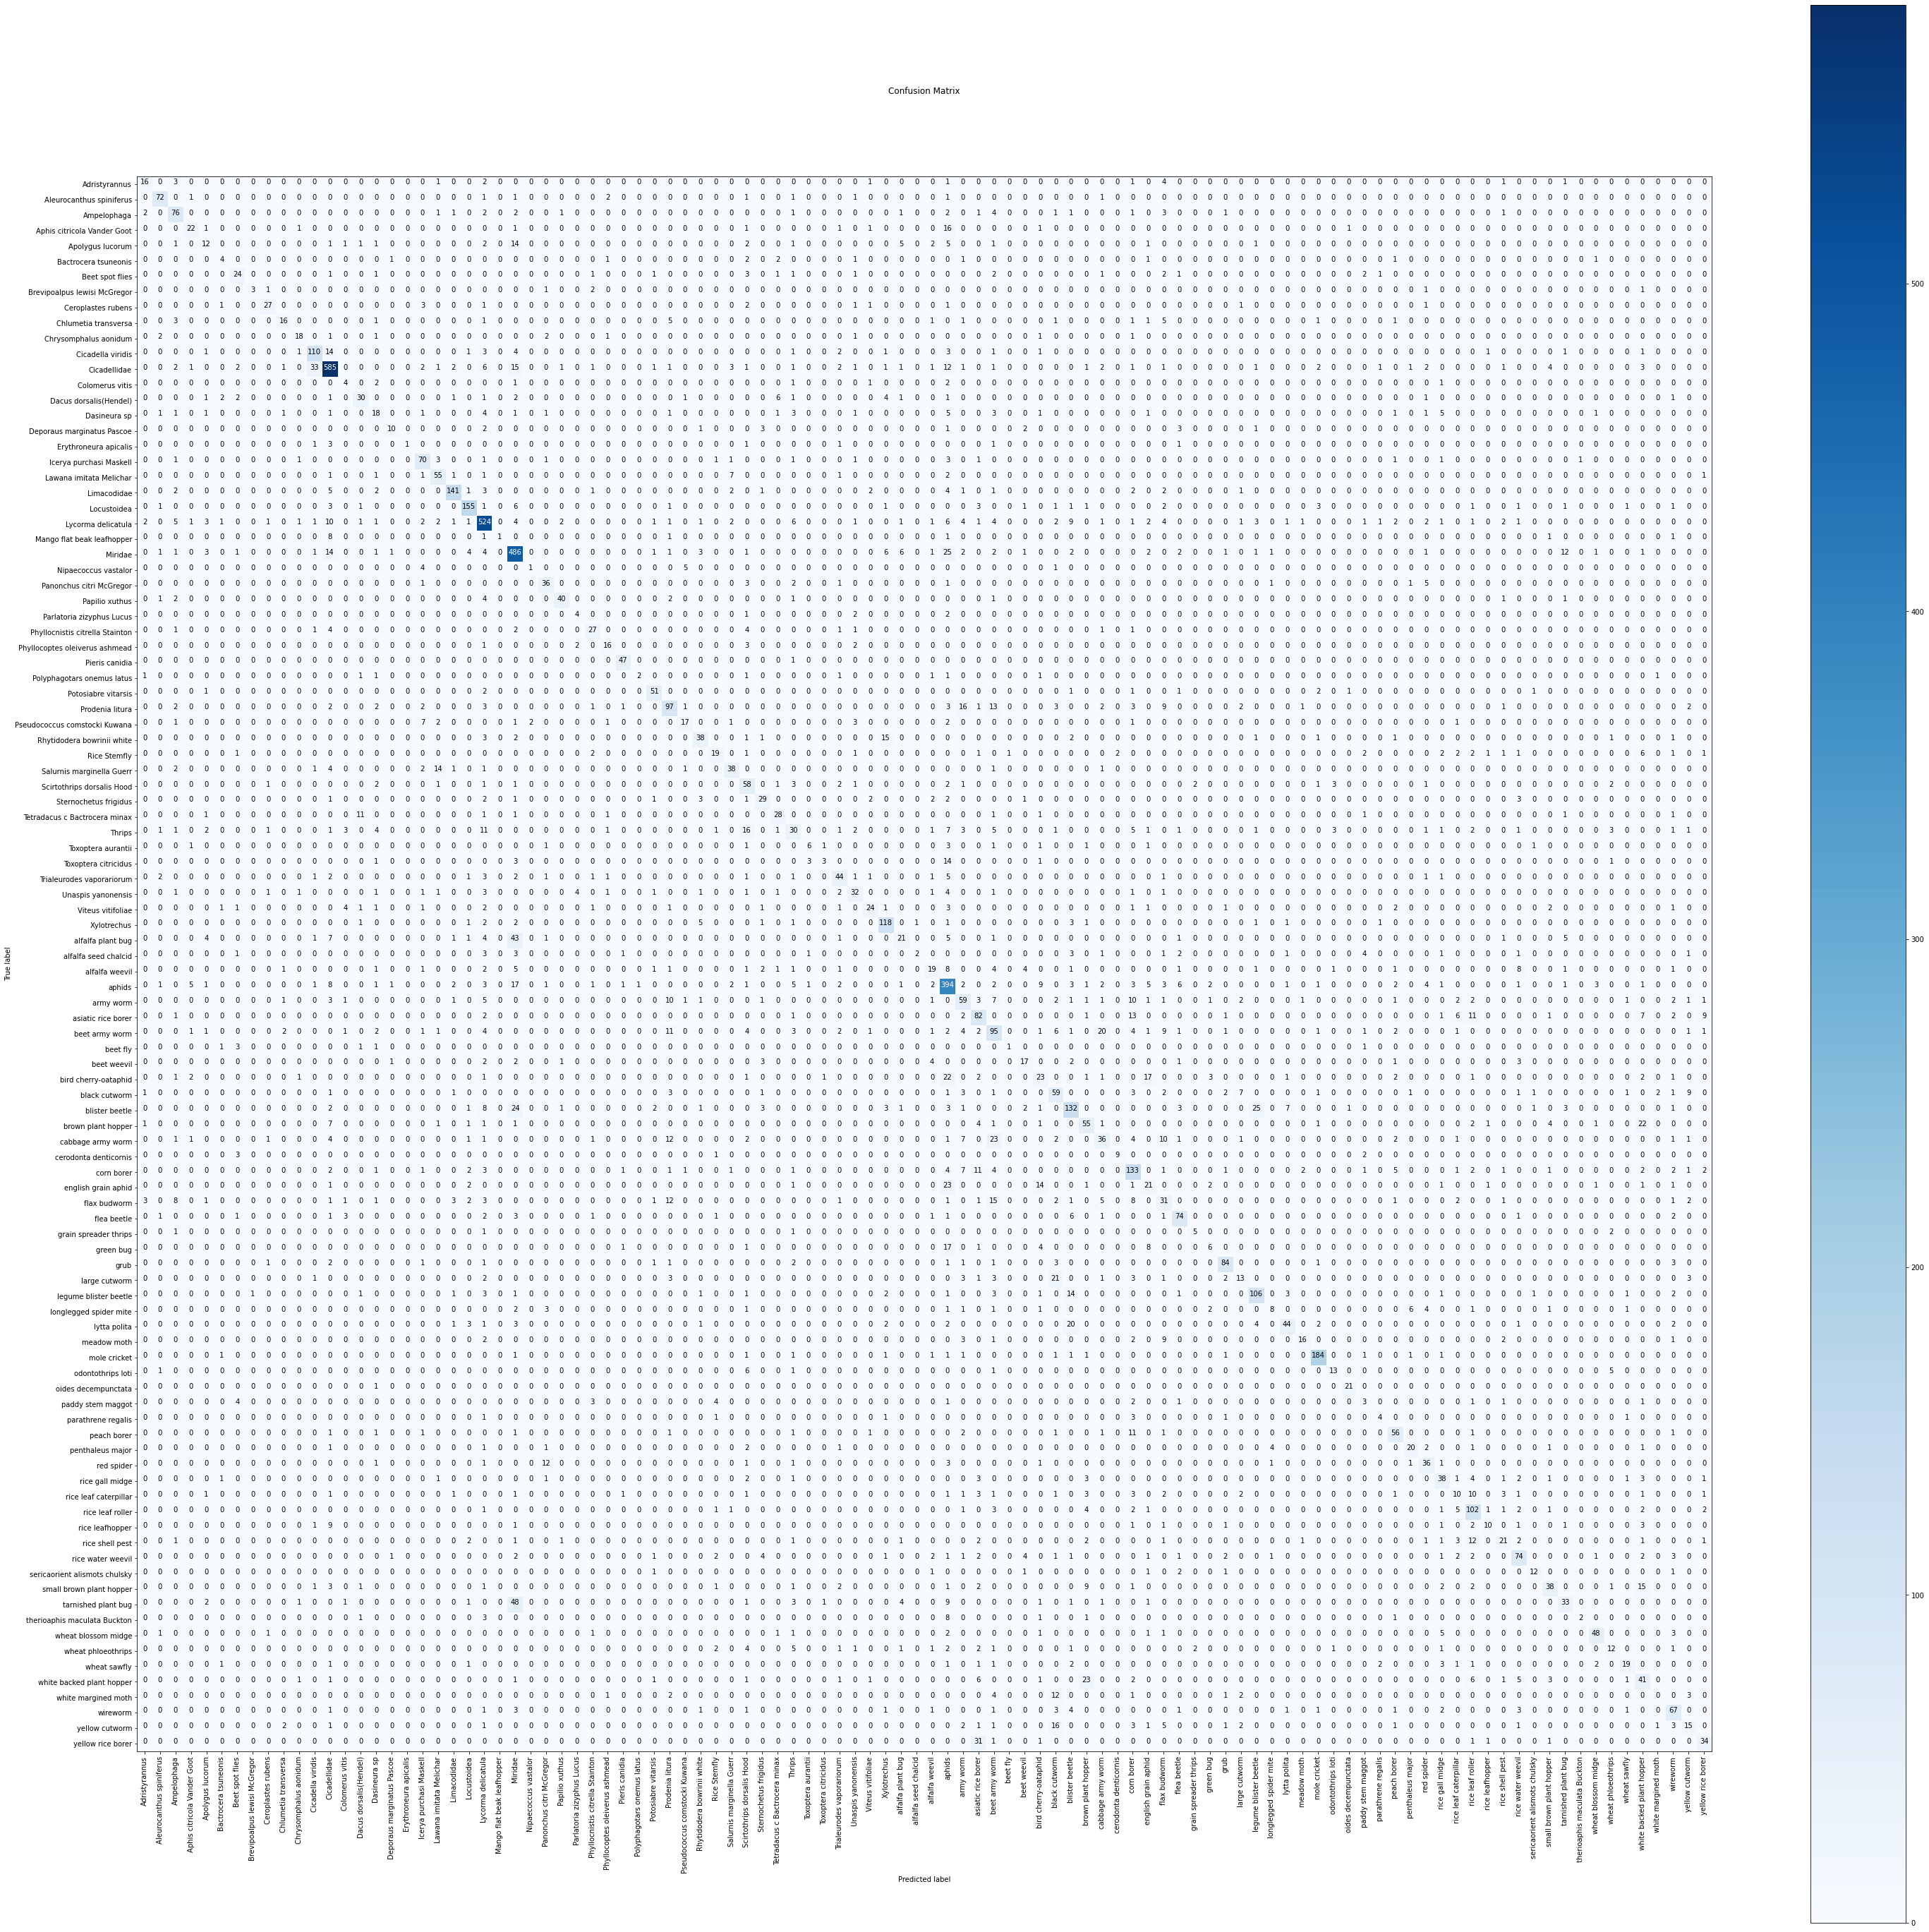

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))
